# **Car Body Damage Detection**
### -Detect scratch, dent, repaint etc. on car body

**Procedure:**
1. Business Problem
2. Machine Learning Problem
3. EDA
4. Data preparation
5. Define the model
6. Preditions
7. Conclusions and Future Research

## 1. **Business Problem**

### 1.1 Introduction
  In used car industry(both marketplace and brick and mortar dealers), apart
from car’s functionality and equipment availability and healthiness, which only can be accessed
by test drive/manual inspection, car body external damages(scratch, dent, repaint etc.) play a vital
role to decide accurate pricing of the vehicle. In most of the cases, these damages are detected
and assessed manually from the car images during the car evaluation process. However, the
latest computer vision frameworks can detect the damage location on the car body and help
pricers to quantify the damage without much manual intervention.
This concept will also help car insurers in assessing the damage automatically and in processing
claims faster. The model can detect the area of damage on a car . The rationale for such a model
is that it can be used by insurance companies for faster processing of claims if users can upload
pics and they can assess damage from them.

 ### 1.2 Problem description
Developing a Deep learning algorithm which can detect car body external damages(scratch, dent, repaint etc.) and help pricers to quantify the damage without much manual intervention. This concept will also help car insurers in assessing the damage automatically and in processing claim faster.

### 1.3 Source/Useful Links

For Segmentation: https://www.tensorflow.org/tutorials/images/segmentation

U-net - https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

Data Preprocessing:
1. https://towardsdatascience.com/cnn-application-detecting-car-exterior-damage-full-implementable-code-1b205e3cb48c

2. https://www.analyticsvidhya.com/blog/2018/07/building-mask-r-cnn-model-detecting-damage-cars-python/

Training and predictions: 
Google Colab https://colab.research.google.com/

### 1.4 Business objectives and constraints: 

1. Maximize dice score

## 2. **Machine Learning Problem**

### 2.1 Data Description
The problem has 3 datasets

a. training : train image files of damaged and full cars

b. validation : validation image files of damaged and full cars

c. Annotated Data(.json file) for masking the damage

### 2.2 Translating to Machine Learning Problem
#### 2.2.1 Type of Machine Learning Problem

There is a Damage and we need to locate the Damage **Image Segmentation**


#### 2.2.2 Performance Metric

**Dice coefficient:** https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient

This metric is used to gauge similarity of two samples. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:

<img src="images/dice_coef.PNG">

<br>
Source: https://www.kaggle.com/c/severstal-steel-defect-detection/overview/evaluation

#### 2.2.3 Machine Learning Objectives and Constraints

**Objective:** 
1. Maximize Dice coefficient

In [0]:
pip install -q git+https://github.com/tensorflow/examples.git

In [0]:
# Using segmentation_models for image segmentation task, https://github.com/qubvel/segmentation_models
! pip install segmentation-models

In [0]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import pathlib
from PIL import Image
import numpy as np
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from datetime import datetime
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input,Flatten,Conv2DTranspose,concatenate, Embedding, GlobalAveragePooling2D, MaxPooling2D, Activation, Dense, Conv2D, BatchNormalization, Dropout

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from IPython.display import clear_output
import matplotlib.pyplot as plt
AUTOTUNE = tf.data.experimental.AUTOTUNE
from sklearn.model_selection import train_test_split

# for TensorBoard
from __future__ import absolute_import, division, print_function, unicode_literals
%tensorflow_version 2.x
import tensorflow as tf
import datetime

from keras import backend as K
import segmentation_models
print(segmentation_models.__version__)

import segmentation_models as sm

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/My Drive/Colab Notebooks/CS2/references/")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join("/content/mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


Segmentation Models: using `keras` framework.
1.0.1


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## 3. **EDA** 

### 3.1 Load images

In [0]:
data_dir = pathlib.Path('/content/drive/My Drive/Colab Notebooks/CS2/references/train/') 
data_dir

PosixPath('/content/drive/My Drive/Colab Notebooks/CS2/references/train')

In [0]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*'))
image_count = len(list(list_ds))
print('Total No. of images in the dataset are: ', image_count)

Total No. of images in the dataset are:  49


In [0]:
#https://www.tensorflow.org/guide/data#decoding_image_data_and_resizing_it

def parse_image(filename, resize = True):
  '''
  Reads an image from a file,
  decodes it into a dense tensor,
  and resizes it to a fixed shape
  '''
  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  if resize:
    image = tf.image.resize(image, [256, 256])
  return image

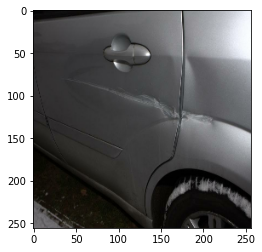

In [0]:
file_path = next(iter(list_ds))
image = parse_image(file_path)

def show(image):
  plt.figure()
  plt.imshow(image)

show(image)

### 3.2 Load Class labels

In [0]:
final = pd.read_csv("/content/drive/My Drive/Colab Notebooks/CS2/train_data.csv", index_col=None).drop("Unnamed: 0", axis = 1)
print(final.shape)
final.head()

(49, 2)


,ImageId,EncodedPixels
0,image67.jpg,77907 1 78425 1 78943 1 79461 1 79979 1 80497 ...
1,image66.jpg,20151 1 20373 47 20595 51 20816 56 21038 60 21...
2,image65.jpg,51421 1 51944 22 52467 44 52989 66 53524 76 54...
3,image64.jpg,206966 1 207375 7 207783 15 208191 23 208599 3...
4,image63.jpg,72538 1 72958 6 73378 11 73798 17 74218 22 746...


In [0]:
# We need a function to convert EncodedPixels into mask
# https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

def rle2mask(mask_rle, shape=(450,300)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    This function is specific to this competition

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    This function is specific to this competition
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

Let's take a look at an image example and it's correponding mask from the dataset.

(256, 256, 3)


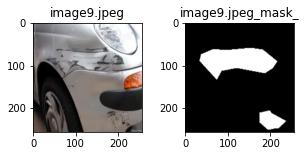

(256, 256, 3)


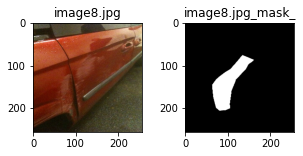

(256, 256, 3)


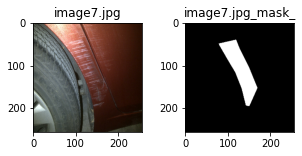

--------------------------------------------------------------------------------


In [0]:
# Visualization: sample images and their masks
cnt = 0
for i in final[['ImageId','EncodedPixels']][40:].values:
    if cnt<3:
            fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(5, 2))
            list_ds1 = tf.data.Dataset.list_files(str(data_dir/i[0])) # image Tesnor
            img = parse_image([i for i in list_ds1][0])
            ax1.imshow(img)
            ax1.set_title(i[0])
            print(img.shape)
            img = parse_image([i for i in list_ds1][0], resize = False)
            mask = rle2mask(i[1], shape=((img.shape[1], img.shape[0])))
            img = mask.reshape((*mask.shape, 1)) #to make shape(m x n x 1)
            tf_img = tf.image.resize(img, [img.shape[0], img.shape[1]]) # Convert to tensor
            gray = tf.image.grayscale_to_rgb(tf_img, name=None) # Gray scale image
            image = tf.image.resize(gray, [256, 256])
            ax2.imshow(image)
            ax2.set_title(i[0]+'_mask_')
            plt.show()
            cnt+=1
            
print('-'*80)

Area of the Damage

,EncodedPixels
count,49.000000
mean,30642.979592
std,53251.541680
min,972.000000
25%,3944.000000
50%,7877.000000
75%,41424.000000
max,316984.000000


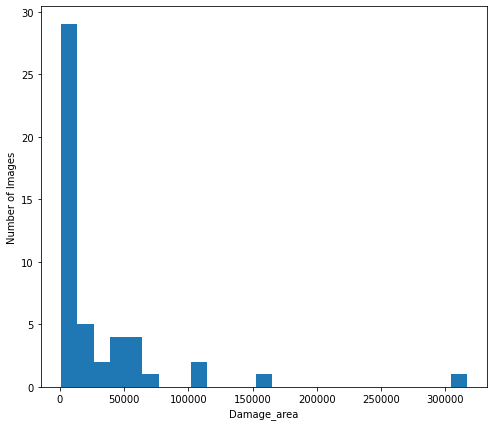

In [0]:
fig, ax = plt.subplots(1,1,figsize=(8, 7))
tmp = final['EncodedPixels'].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]]))
ax.hist(tmp.values,bins = 25)
ax.set_xlabel('Damage_area')
ax.set_ylabel('Number of Images')

tmp = final['EncodedPixels'].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]])).describe()
area_df = pd.DataFrame(tmp)
area_df

## 4. **Data preparation**

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [256, 256])

In [0]:
def display1(display_list):
  plt.figure(figsize=(8, 8))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [0]:
# Create tensors from csv file of train images, masks for preparing data
train_data = pd.DataFrame()
for i in final[['ImageId','EncodedPixels']].values:
    list_ds1 = tf.data.Dataset.list_files(str(data_dir/i[0])) # image Tesnor
    image = parse_image([i for i in list_ds1][0], resize = False)
    mask1 = rle2mask(i[1], shape=((image.shape[1], image.shape[0])))
    mask1 = cv2.resize(mask1, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    img1 = mask1.reshape((*mask1.shape, 1)) #to make shape(m x n x 1)
    tf_img = tf.image.resize(img1, [img1.shape[0], img1.shape[1]]) # Convert to tensor
    gray = tf.image.grayscale_to_rgb(tf_img, name=None) # Gray scale image

    image = parse_image([i for i in list_ds1][0], resize = True)
    x2 = pd.DataFrame({"ImageId":i[0], "image":[image], "mask":[gray]})
    train_data = pd.concat([train_data, x2], ignore_index=True)    

In [0]:
train_data.shape

(49, 3)

In [0]:
X = train_data.copy()
train_df, test_df = train_test_split(X, test_size = 0.1, random_state=42)
print(train_df.shape, test_df.shape)

(44, 3) (5, 3)


### 4.1 Load data Using tf.data

In [0]:
train = tf.data.Dataset.from_tensor_slices((list(train_df['image']), list(train_df['mask'])))
test = tf.data.Dataset.from_tensor_slices((list(test_df['image']), list(test_df['mask'])))
train

<TensorSliceDataset shapes: ((256, 256, 3), (256, 256, 3)), types: (tf.float32, tf.float32)>

In [0]:
for image, label in train.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

Image shape:  (256, 256, 3)
Label:  (256, 256, 3)


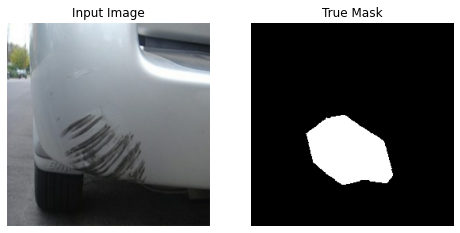

In [0]:
for image, mask in train.take(27):
  sample_image, sample_mask = image, mask
display1([sample_image, sample_mask])

In [0]:
TRAIN_LENGTH = train_df.shape[0]
BATCH_SIZE = 1
BUFFER_SIZE = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
OUTPUT_CHANNELS = 3

In [0]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32)/256.0 - 1
  #input_mask -= 1
  return input_image, input_mask

In [0]:
def load_image_train(input_image, input_mask):
  input_image = tf.image.resize(input_image, (256, 256))
  input_mask = tf.image.resize(input_mask, (256, 256))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [0]:
def load_image_test(input_image, input_mask):
  input_image = tf.image.resize(input_image, (256, 256))
  input_mask = tf.image.resize(input_mask, (256, 256))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [0]:
train_dataset = train.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test.map(load_image_test)

In [0]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.map(normalize)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.map(normalize)

In [0]:
for image, label in train_dataset.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

Image shape:  (1, 256, 256, 3)
Label:  (1, 256, 256, 3)
